In [2]:
from sklearn.model_selection import train_test_split,cross_val_score, KFold,validation_curve,GridSearchCV
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [4]:

data_reg=pd.read_excel('data_reg.xlsx')
data_class=pd.read_excel('data_class.xlsx')
data_reg_prep=pd.read_excel('data_reg_prep.xlsx')
data_class_prep=pd.read_excel('data_class_prep.xlsx')

data_reg_temp = data_reg.drop("SalePrice",axis = 1)
cols_temp = ["OverallQual","OverallCond","IsRemodGar","IsRemod"]
data_reg_temp[cols_temp]=data_reg_temp[cols_temp].astype("object")

cat_cols = data_reg_temp.select_dtypes(include = "object").columns.tolist()
print(len(cat_cols))
print(cat_cols)

num_cols = data_reg_temp.select_dtypes(include="number").columns.tolist()
print(len(num_cols))
print(num_cols)

Xtrain,Xtest,Ytrain,Ytest = train_test_split(data_reg_temp,data_reg["SalePrice"],test_size =0.3,random_state=0)
Xtrain = Xtrain.sort_index()
Xtest = Xtest.sort_index()
Ytrain= Ytrain.sort_index()
Ytest = Ytest.sort_index()

Xtrain_index = Xtrain.index.tolist()
Xtest_index = Xtest.index.tolist()

Xtrain_cat = Xtrain[cat_cols]

Xtrain_num = Xtrain[num_cols]
train_mean= Xtrain_num.mean()
train_std = np.sqrt(Xtrain_num.var())

Xtest_cat = Xtest[cat_cols]
Xtest_num = Xtest[num_cols]

Xtrain_num_std = Xtrain_num.apply(lambda x: (x - x.mean()) / np.sqrt(x.var())) 
Xtest_num_std = Xtest_num.copy()
for i in num_cols:
    Xtest_num_std[i] = (Xtest_num_std[i] - train_mean[i]) / train_std[i]

#axis = 0 caculate the mean or var through columns ,which is the default value in apply
# data_num_nor = data_num[numeric_cols].apply(lambda x: (x - x.min()) / (x.max(axis=0) - x.min(axis=0)))

#dummy的话最好一起dummy，因为有可能 test dataset 没有一些分类，导致train和test 的dummy的维度不一致

cat_dummy = data_reg_temp[cat_cols].copy()
for i in cat_cols:
    dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
    cat_dummy = pd.concat([cat_dummy,dummy_df], axis=1)
    cat_dummy = cat_dummy.drop(i, axis = 1)
print(cat_dummy.shape) 

Xtest_cat_dummy = cat_dummy.iloc[Xtest_index,:]
Xtrain_cat_dummy = cat_dummy.iloc[Xtrain_index,:]

Xtrain_lr = pd.concat((Xtrain_num_std,Xtrain_cat_dummy),axis = 1)
Xtest_lr = pd.concat((Xtest_num_std,Xtest_cat_dummy),axis = 1)
Ytrain_lr = Ytrain
Ytest_lr = Ytest

Xtrain_tree = pd.concat((Xtrain_num,Xtrain_cat),axis = 1)
Xtest_tree = pd.concat((Xtest_num,Xtest_cat),axis = 1)
Ytrain_tree = data_class.iloc[Xtrain_index,:]["PriceLevel"]
Ytest_tree = data_class.iloc[Xtest_index,:]["PriceLevel"]


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column in Xtrain_tree
for column in Xtrain_tree.columns:
    # Check if the column is categorical (object data type)
    if Xtrain_tree[column].dtype == 'object':
        # Fit and transform the column with LabelEncoder
        Xtrain_tree[column] = label_encoder.fit_transform(Xtrain_tree[column])

for column in Xtest_tree.columns:
    # Check if the column is categorical (object data type)
    if Xtest_tree[column].dtype == 'object':
        # Fit and transform the column with LabelEncoder
        Xtest_tree[column] = label_encoder.fit_transform(Xtest_tree[column])

# Now Xtrain_tree contains the label-encoded categorical variables


20
['MSZoning', 'LotShape', 'HouseStyle', 'OverallQual', 'OverallCond', 'Exterior1st', 'MasVnrType', 'Foundation', 'BsmtQual', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageQual', 'PavedDrive', 'SaleType', 'SaleCondition', 'IsRemodGar', 'IsRemod']
9
['LotArea', 'YearBuilt', 'MasVnrArea', 'Fireplaces', 'GarAreaPerCar', 'GrLivAreaPerRoom', 'TotalHouseSF', 'TotalFullBath', 'TotalPorchSF']
(2930, 125)


C:\Users\T480S\AppData\Local\Temp\ipykernel_12072\3440473200.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
C:\Users\T480S\AppData\Local\Temp\ipykernel_12072\3440473200.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
C:\Users\T480S\AppData\Local\Temp\ipykernel_12072\3440473200.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
C:\Users\T480S\AppData\Local\Temp\ipykernel_12072\3440473200.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when

In [4]:
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(Xtrain_tree, Ytrain_lr)
AdaBoostRegressor(n_estimators=100, random_state=0)
regr.score(Xtrain_tree, Ytrain_lr)

0.8759134735940983

In [10]:
kf = KFold(n_splits=2, shuffle=True, random_state=0)
custom_decision_tree = DecisionTreeRegressor(max_depth=16
                                            ,min_samples_leaf= 1
                                            ,min_samples_split = 4)

parameters = { 'n_estimators':[*range(100,601,50)]
                ,'learning_rate':np.arange(0.1,1.1,0.1)
                }
adar = AdaBoostRegressor(estimator=custom_decision_tree,random_state=0)
GS_mae = GridSearchCV(adar, parameters, cv=kf, scoring="neg_mean_absolute_error")
GS_mae.fit(Xtrain_tree, Ytrain_lr)
GS_mse = GridSearchCV(adar, parameters, cv=kf, scoring="neg_mean_squared_error")
GS_mse.fit(Xtrain_tree, Ytrain_lr)
GS_r2 = GridSearchCV(adar, parameters, cv=kf, scoring="r2")
GS_r2.fit(Xtrain_tree, Ytrain_lr)

 
print(GS_mae.best_params_)
print(GS_mae.best_score_)

{'learning_rate': 1.0, 'n_estimators': 550}
-16329.575379444992


In [13]:
print(GS_r2.best_params_)
print(GS_r2.best_score_)
print(GS_mse.best_params_)
print(np.sqrt(-GS_mse.best_score_))

{'learning_rate': 1.0, 'n_estimators': 550}
0.8919643473007344
{'learning_rate': 1.0, 'n_estimators': 550}
25812.71335703002


In [15]:
kf = KFold(n_splits=2, shuffle=True, random_state=0)
custom_decision_tree = DecisionTreeRegressor(max_depth=16
                                            ,min_samples_leaf= 1
                                            ,min_samples_split = 4)

parameters = { 'n_estimators':[*range(520,581,10)]
                ,'learning_rate':np.arange(1,1.3,0.1)
                }
adar = AdaBoostRegressor(estimator=custom_decision_tree,random_state=0)
# GS_mae = GridSearchCV(adar, parameters, cv=kf, scoring="neg_mean_absolute_error")
# GS_mae.fit(Xtrain_tree, Ytrain_lr)
# GS_mse = GridSearchCV(adar, parameters, cv=kf, scoring="neg_mean_squared_error")
# GS_mse.fit(Xtrain_tree, Ytrain_lr)
GS_r2 = GridSearchCV(adar, parameters, cv=kf, scoring="r2")
GS_r2.fit(Xtrain_tree, Ytrain_lr)

GridSearchCV(cv=KFold(n_splits=2, random_state=0, shuffle=True),
             estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=16,
                                                                         min_samples_split=4),
                                         random_state=0),
             param_grid={'learning_rate': array([1. , 1.1, 1.2, 1.3]),
                         'n_estimators': [520, 530, 540, 550, 560, 570, 580]},
             scoring='r2')

In [19]:
GS_mae = GridSearchCV(adar, parameters, cv=kf, scoring="neg_mean_absolute_error")
GS_mae.fit(Xtrain_tree, Ytrain_lr)
GS_mse = GridSearchCV(adar, parameters, cv=kf, scoring="neg_mean_squared_error")
GS_mse.fit(Xtrain_tree, Ytrain_lr)

GridSearchCV(cv=KFold(n_splits=2, random_state=0, shuffle=True),
             estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=16,
                                                                         min_samples_split=4),
                                         random_state=0),
             param_grid={'learning_rate': array([1. , 1.1, 1.2, 1.3]),
                         'n_estimators': [520, 530, 540, 550, 560, 570, 580]},
             scoring='neg_mean_squared_error')

In [20]:
# Extract results
n_estimators_values = parameters['n_estimators']
max_depth_values = parameters['learning_rate']

results_mae = GS_mae.cv_results_
mean_mae = -results_mae['mean_test_score']

results_mse = GS_mse.cv_results_
mean_rmse = np.sqrt(-results_mse['mean_test_score'])

results_r2 = GS_r2.cv_results_
mean_r2 = results_r2['mean_test_score']

# Reshape mean_mae to a 2D array for plotting
mean_mae = mean_mae.reshape(len(max_depth_values), len(n_estimators_values))
mean_rmse = mean_rmse.reshape(len(max_depth_values), len(n_estimators_values))
mean_r2 = mean_r2.reshape(len(max_depth_values), len(n_estimators_values))

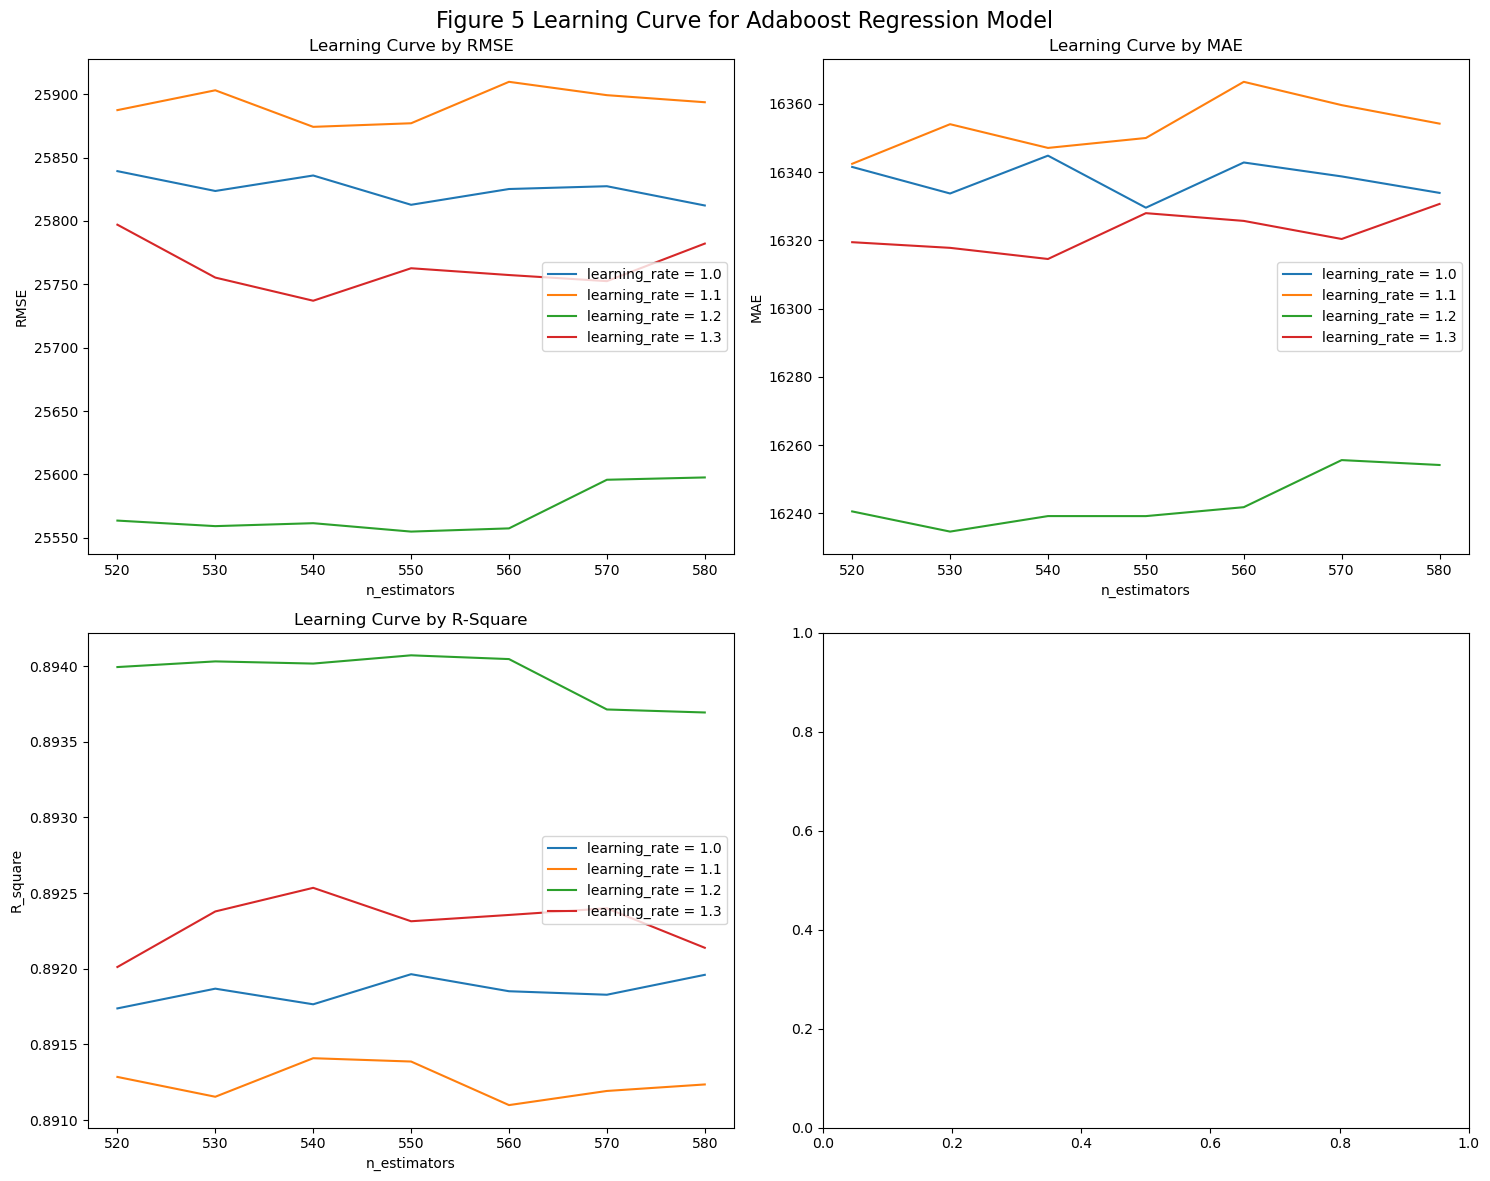

0.8940717827785112 25909.72966163388 16366.479350217109


In [23]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Figure 5 Learning Curve for Adaboost Regression Model", fontsize=16)
# Plot the R2 curve
for i, max_depth in enumerate(max_depth_values):
    axs[1,0].plot(n_estimators_values, mean_r2[i], label=f'learning_rate = {round(max_depth,2)}')
axs[1,0].set_title("Learning Curve by R-Square")
axs[1,0].legend()
axs[1,0].set_xlabel("n_estimators")
axs[1,0].set_ylabel("R_square")
# Plot the MAE curve
for i, max_depth in enumerate(max_depth_values):
    axs[0,1].plot(n_estimators_values, mean_mae[i], label=f'learning_rate = {round(max_depth,2)}')
axs[0,1].set_title("Learning Curve by MAE")
axs[0,1].legend()
axs[0,1].set_xlabel("n_estimators")
axs[0,1].set_ylabel("MAE")

for i, max_depth in enumerate(max_depth_values):
    axs[0,0].plot(n_estimators_values, mean_rmse[i], label=f'learning_rate = {round(max_depth,2)}')
axs[0,0].set_title("Learning Curve by RMSE")
axs[0,0].legend()
axs[0,0].set_xlabel("n_estimators")
axs[0,0].set_ylabel("RMSE")

# Find the maximum R2 value and annotate it on the R2 plot
# max_r2_alpha = n_estimators_values[np.argmax(mean_r2)]
# max_r2 = np.max(ridge_r2)
# axs[1,0].annotate(f"Max R2: {max_r2:.3f} (alpha={max_r2_alpha:.3f})", xy=(max_r2_alpha, max_r2))                

# # Find the minimum MAE value and annotate it on the MAE plot
# min_mae_alpha = alpharange[np.argmin(ridge_mae)]
# min_mae = np.min(ridge_mae)
# axs[0,1].annotate(f"Min MAE: {min_mae:.3f} (alpha={max_r2_alpha:.3f})", xy=(min_mae_alpha, min_mae))

# min_rmse_alpha = alpharange[np.argmin(ridge_rmse)]
# min_rmse = np.min(ridge_rmse)
# axs[0,0].annotate(f"Min RMSE: {min_rmse:.3f} (alpha={min_rmse_alpha:.3f})", xy=(min_rmse_alpha, min_rmse))

plt.tight_layout()
plt.show()

print(np.max(mean_r2),np.max(mean_rmse),np.max(mean_mae))

In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
custom_decision_tree = DecisionTreeRegressor(max_depth=16
                                            ,min_samples_leaf= 1
                                            ,min_samples_split = 4)

parameters = { 'n_estimators':[530]
                ,'learning_rate':[1.2]
                }
adar = AdaBoostRegressor(estimator=custom_decision_tree,random_state=0)
GS_mae = GridSearchCV(adar, parameters, cv=kf, scoring="neg_mean_absolute_error")
GS_mae.fit(Xtest_tree, Ytest_lr)
GS_mse = GridSearchCV(adar, parameters, cv=kf, scoring="neg_mean_squared_error")
GS_mse.fit(Xtest_tree, Ytest_lr)
GS_r2 = GridSearchCV(adar, parameters, cv=kf, scoring="r2")
GS_r2.fit(Xtest_tree, Ytest_lr)

n_estimators_values = parameters['n_estimators']
max_depth_values = parameters['learning_rate']

results_mae = GS_mae.cv_results_
mean_mae = -results_mae['mean_test_score']

results_mse = GS_mse.cv_results_
mean_rmse = np.sqrt(-results_mse['mean_test_score'])

results_r2 = GS_r2.cv_results_
mean_r2 = results_r2['mean_test_score']
print(np.max(mean_r2),np.max(mean_rmse),np.max(mean_mae))

NameError: name 'Xtest_tree' is not defined

# classification

In [9]:
from sklearn.ensemble import AdaBoostClassifier

kf = KFold(n_splits=5, shuffle=True, random_state=0)

adac = AdaBoostClassifier(n_estimators=100, learning_rate=0.5)
adac1 = adac.fit(Xtrain_tree,Ytrain_tree)
print(adac.score(Xtrain_tree, Ytrain_tree))

0.7323256947830327


In [10]:

score_lst =[]
for i in range(71,902,10):
    rfc = AdaBoostClassifier(n_estimators = i,random_state = 0)
    ss= cross_val_score(rfc,Xtrain_tree,Ytrain_tree,cv = 4,scoring = 'accuracy').mean()
    score_lst.append(ss)

0.7537948876096491 101
0.7552511650219298 121
0.7567169605872319 151
0.7572042900219298 161


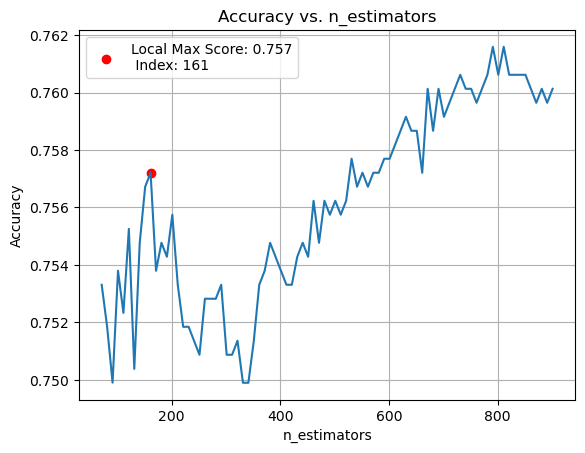

In [14]:
max_score = 0
for index1,i in enumerate(range(71,902,10)):
    if i >= 100 and i <= 301:
        if score_lst[index1] > max_score:
            max_score = score_lst[index1]
            max_score_index = i
            print(max_score,max_score_index)

plt.plot(range(71, 902, 10), score_lst)
plt.scatter(max_score_index, max_score, color='red', label=f'Local Max Score: {max_score:.3f}\n Index: {max_score_index}')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. n_estimators')
plt.legend()
plt.grid()
plt.show()

In [46]:
from sklearn.tree import DecisionTreeClassifier
custom_decision_tree = DecisionTreeClassifier(max_depth=14
                                            ,min_samples_leaf= 1
                                            ,min_samples_split = 3)

# parameters = { 'n_estimators':[*range(71,301,10)]
#                 ,'learning_rate':np.arange(1,1.3,0.1)
#                 }
# adac = AdaBoostClassifier(estimator=custom_decision_tree,random_state=0)

score_lst =[]
for i in range(51,502,10):
    adac = AdaBoostClassifier(estimator=custom_decision_tree,n_estimators = i,random_state = 0)
    ss= cross_val_score(adac,Xtrain_tree,Ytrain_tree,cv = 5,scoring = 'accuracy').mean()
    score_lst.append(ss)

In [44]:
len(score_lst)

13

0.7586671414159397 101
0.7611073526793662 121
0.7630550115720135 191
0.7640294344549284 211


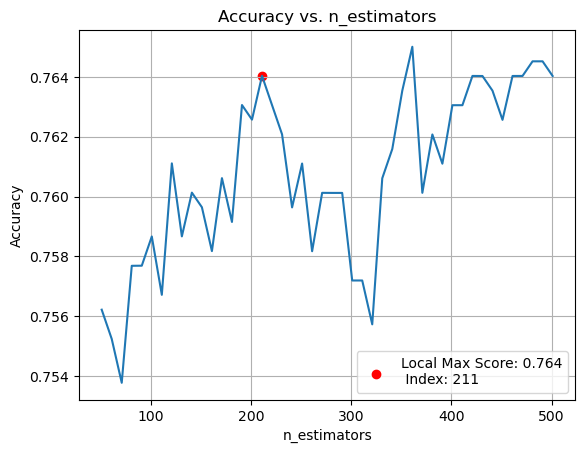

In [47]:
max_score = 0
for index1,i in enumerate(range(51,502,10)):
    if i >= 100 and i <= 301:
        if score_lst[index1] > max_score:
            max_score = score_lst[index1]
            max_score_index = i
            print(max_score,max_score_index)

plt.plot(range(51,502,10), score_lst)
plt.scatter(max_score_index, max_score, color='red', label=f'Local Max Score: {max_score:.3f}\n Index: {max_score_index}')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. n_estimators')
plt.legend()
plt.grid()
plt.show()

In [42]:
score_lst

[0.7055169118542886,
 0.7011204769736842,
 0.6903982775950293,
 0.6908884624756335,
 0.6860227826510721,
 0.6753024869030214,
 0.6733493619030214,
 0.6787185520224172,
 0.6743287798489279,
 0.6821336653265108,
 0.6777400858918129,
 0.6772508528265107,
 0.6782112344663742]

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

parameters = { 'n_estimators':[*range(231,272,10)]
                ,"learning_rate":np.arange(0.5,0.9,0.1)
                }
adac = AdaBoostClassifier(estimator=custom_decision_tree,random_state=0)
GS_acc = GridSearchCV(adac, parameters, cv=kf,scoring = "accuracy")
GS_acc.fit(Xtrain_tree,Ytrain_tree)



In [38]:
GS_recall = GridSearchCV(adac, parameters, cv=kf,scoring = "recall_macro")
GS_recall.fit(Xtrain_tree,Ytrain_tree)
GS_roc = GridSearchCV(adac, parameters, cv=kf,scoring = "roc_auc_ovr")
GS_roc.fit(Xtrain_tree,Ytrain_tree)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=14,
                                                                           min_samples_split=3),
                                          random_state=0),
             param_grid={'learning_rate': array([0.5, 0.6, 0.7, 0.8]),
                         'n_estimators': [231, 241, 251, 261, 271]},
             scoring='roc_auc_ovr')

In [39]:
print(GS_acc.best_params_)
print(GS_acc.best_score_)

{'learning_rate': 0.7999999999999999, 'n_estimators': 231}
0.7723078749035664


In [52]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

parameters = { 'n_estimators':[231]
                ,"learning_rate":[0.8]
                }
adac = AdaBoostClassifier(estimator=custom_decision_tree,random_state=0)
GS_acc = GridSearchCV(adac, parameters, cv=kf,scoring = "accuracy")
GS_acc.fit(Xtrain_tree,Ytrain_tree)
GS_recall = GridSearchCV(adac, parameters, cv=kf,scoring = "recall_macro")
GS_recall.fit(Xtrain_tree,Ytrain_tree)
GS_roc = GridSearchCV(adac, parameters, cv=kf,scoring = "roc_auc_ovr")
GS_roc.fit(Xtrain_tree,Ytrain_tree)



GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=14,
                                                                           min_samples_split=3),
                                          random_state=0),
             param_grid={'learning_rate': [0.8], 'n_estimators': [231]},
             scoring='roc_auc_ovr')

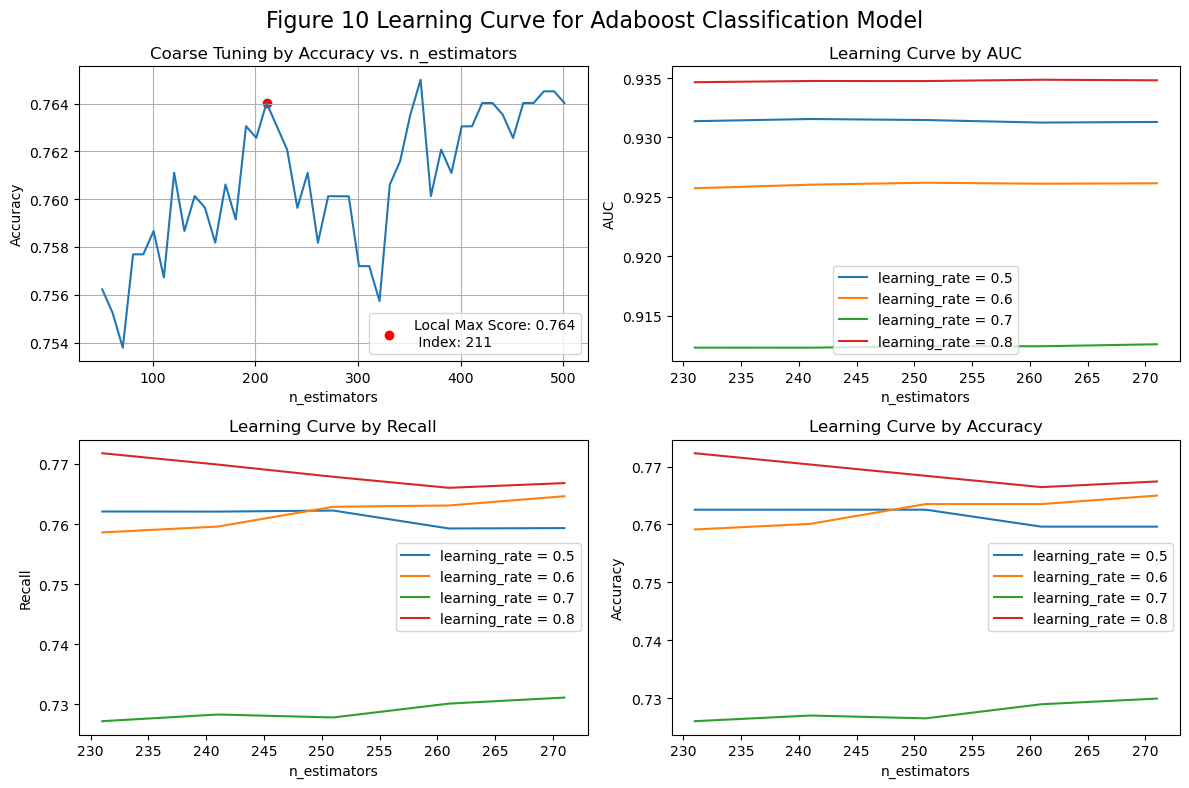

0.7723078749035664 0.7717791215379135 0.9346487488300902


In [48]:
# Extract results
n_estimators_values = parameters['n_estimators']
max_depth_values = parameters['learning_rate']

results_acc = GS_acc.cv_results_
mean_acc = results_acc['mean_test_score']

results_recall = GS_recall.cv_results_
mean_recall = results_recall['mean_test_score']

results_roc = GS_roc.cv_results_
mean_roc = results_roc['mean_test_score']

#Reshape mean_mae to a 2D array for plotting
mean_acc = mean_acc.reshape(len(max_depth_values), len(n_estimators_values))
mean_recall = mean_recall.reshape(len(max_depth_values), len(n_estimators_values))
mean_roc = mean_roc.reshape(len(max_depth_values), len(n_estimators_values))

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Figure 10 Learning Curve for Adaboost Classification Model", fontsize=16)


axs[0,0].plot(range(51,502,10), score_lst)
axs[0,0].scatter(max_score_index, max_score, color='red', label=f'Local Max Score: {max_score:.3f}\n Index: {max_score_index}')
axs[0,0].set_title("Coarse Tuning by Accuracy vs. n_estimators")
axs[0,0].legend()
axs[0,0].grid()
axs[0,0].set_xlabel("n_estimators")
axs[0,0].set_ylabel("Accuracy")


# Plot the Recall curve
for i, max_depth in enumerate(max_depth_values):
    axs[1,0].plot(n_estimators_values, mean_recall[i], label=f'learning_rate = {round(max_depth,2)}')
axs[1,0].set_title("Learning Curve by Recall")
axs[1,0].legend()
axs[1,0].set_xlabel("n_estimators")
axs[1,0].set_ylabel("Recall")
# Plot the AUC curve
for i, max_depth in enumerate(max_depth_values):
    axs[0,1].plot(n_estimators_values, mean_roc[i], label=f'learning_rate = {round(max_depth,2)}')
axs[0,1].set_title("Learning Curve by AUC")
axs[0,1].legend()
axs[0,1].set_xlabel("n_estimators")
axs[0,1].set_ylabel("AUC")

for i, max_depth in enumerate(max_depth_values):
    axs[1,1].plot(n_estimators_values, mean_acc[i], label=f'learning_rate = {round(max_depth,2)}')
axs[1,1].set_title("Learning Curve by Accuracy")
axs[1,1].legend()
axs[1,1].set_xlabel("n_estimators")
axs[1,1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()
index1 = np.argmax(mean_acc.ravel())
print(mean_acc.ravel()[index1],mean_recall.ravel()[index1],mean_roc.ravel()[index1])

In [50]:
adac= AdaBoostClassifier(estimator=custom_decision_tree,n_estimators= 231, learning_rate= 0.8, random_state=0).fit(Xtrain_tree, Ytrain_tree)
# Xtest_tree = Xtrain_tree
# Ytest_tree = Ytrain_tree
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

# Step 2: Make predictions on Xtest_lr
predictions = adac.predict(Xtest_tree)
prob = adac.predict_proba(Xtest_tree)
# Step 3: Calculate accuracy
accuracy = accuracy_score(Ytest_tree, predictions)

# Step 4: Calculate recall
recall = recall_score(Ytest_tree, predictions, average='macro')  # 'macro' for multiclass classification

# Step 5: Calculate AUC
auc = roc_auc_score(Ytest_tree, prob, multi_class='ovr')

# Print the results
print("Accuracy:", accuracy)
print("Recall:", recall)
print("AUC:", auc)

Accuracy: 0.764505119453925
Recall: 0.7643473964841943
AUC: 0.9387003364830496
